# Case Study 1 - Multiple Runs

This notebook serves as a second part of the **case1.ipynb** notebook. Here we run the same experiment several times, with different train/test splits, in order to test the average results obtained. We do this to test if a preprocessing step manages to improve the model's result with some statistical significance. In the **case1.ipynb** notebook we tested a single train/test split, and some of the results we observed might not hold for different splits. Maybe we just got lucky with our train/test split. To avoid these pitfalls, we will try each experiment several times and record the average behavior.

This notebook uses the ```seaborn```, which is not listed as a requirement for this library. Therefore, make sure to install it before running this notebook. To install it, use the following:

```console
> pip install seaborn
```

## 0 - Defining Basic Functionalities

The next cell contains several helper functions that will be used throughout this notebook. Here we create some functions for training a model and assessing its performance in a test set. We also create functions for encoding the data using the **dataprocessing** library. Some functions are tailored specifically for the dataset used here and won't generalize to other datasets.

In [7]:
import pandas as pd
import numpy as np
import uci_dataset as database
from matplotlib.pyplot import figure

from raimitigations.utils import train_model_fetch_results, split_data
import raimitigations.dataprocessing as dp
import case_study_utils as cs

N_EXEC = 100

USE_AUC_TH = True

In [8]:
def get_encoders(df):
    """
    Creates the encoder objects used to encode the dataset.
    The categorical features that have a given ordering are
    encoded using ordinal encoding. The other categorical
    features encoded using one-hot encoding.
    """
    age_order = df['age'].unique()
    age_order.sort()
    tumor_size_order = df['tumor-size'].unique()
    tumor_size_order.sort()
    inv_nodes_order = df['inv-nodes'].unique()
    inv_nodes_order.sort()

    # Encode 'tumor-size', and 'inv-nodes' using ordinal encoding
    enc_ord = dp.EncoderOrdinal(col_encode=["age", "tumor-size", "inv-nodes"],
                                categories={"age":age_order,
                                            "tumor-size":tumor_size_order, 
                                            "inv-nodes":inv_nodes_order},
                                verbose=False
                            )
    enc_ohe = dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)
    return enc_ord, enc_ohe


# -----------------------------------
def encode_case1(df):
    """
    Encodes the full dataset using one-hot and ordinal encodings.
    """
    enc_ord, enc_ohe = get_encoders(df)
    enc_ord.fit(df)
    proc_df = enc_ord.transform(df)

    # Encode the remaining categorical columns using One-Hot Encoding
    enc_ohe.fit(proc_df)
    proc_df = enc_ohe.transform(proc_df)
    return proc_df


# -----------------------------------
def encode_case1_train_test(train_x, test_x):
    """
    Encodes the train and test datasets (without the label column)
    using one-hot and ordinal encodings.
    """
    enc_ord, enc_ohe = get_encoders(train_x)
    enc_ord.fit(train_x)
    train_x_enc = enc_ord.transform(train_x)
    test_x_enc = enc_ord.transform(test_x)

    enc_ohe.fit(train_x_enc)
    train_x_enc = enc_ohe.transform(train_x_enc)
    test_x_enc = enc_ohe.transform(test_x_enc)
    return train_x_enc, test_x_enc


# -----------------------------------
def impute_case1(df):
    """
    Imputes missing data from the full dataset.
    """
    imputer = dp.BasicImputer(verbose=False)
    imputer.fit(df)
    proc_df = imputer.transform(df)
    return proc_df


# -----------------------------------
def impute_case1_train_test(train_x, test_x):
    """
    Imputes missing data from the train and test
    datasets (without the label column).
    """
    imputer = dp.BasicImputer(verbose=False)
    imputer.fit(train_x)
    train_x_enc = imputer.transform(train_x)
    test_x_enc = imputer.transform(test_x)
    return train_x_enc, test_x_enc

In [9]:
def test_base(df, label_col, n_exec, model_name):
    """
    Runs the baseline experiment several times and returns a dictionary
    with the results obtained.
    """
    result_list = []
    proc_df = encode_case1(df)
    proc_df = impute_case1(proc_df)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = split_data(proc_df, label_col, test_size=0.25)
        result = train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat


# -----------------------------------
def test_corr(df, label_col, n_exec, model_name):
    """
    Similar to the test_base function, but before starting the experiments,
    remove all correlated features using the remove_corr_feat function from
    the case_study_utils module. Returns a dictionary with the results
    obtained.
    """
    result_list = []
    proc_df = cs.remove_corr_feat(df, label_col)
    result_stat = test_base(proc_df, label_col, n_exec, model_name)
    return result_stat


# -----------------------------------
def test_smote(df, label_col, n_exec, model_name, rcorr=True, feat_sel_type=None, art_str=None, under=False):
    """
    Runs several experiments where artificial instances are created using SMOTE, with
    each run having different artificial instances. Returns a dictionary with the
    results obtained.
    """
    result_list = []
    proc_df = df
    if rcorr:
        proc_df = cs.remove_corr_feat(proc_df, label_col)
    proc_df = encode_case1(proc_df)
    proc_df = impute_case1(proc_df)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = split_data(proc_df, label_col, test_size=0.25)
        if art_str is not None:
            train_x, train_y = cs.artificial_smote(train_x, train_y, art_str, under)
        if feat_sel_type is not None:
            train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
        result = train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat


# -----------------------------------
def test_ctgan_first(df, label_col, n_exec, model_name, rcorr=True, feat_sel_type=None, art_str=None, savefile=None):
    """
    Runs several experiments where artificial instances are created using the CTGAN,
    with each run having different artificial instances. Returns a dictionary with the
    results obtained.
    """
    result_list = []
    proc_df = df
    if rcorr:
        proc_df = cs.remove_corr_feat(proc_df, label_col)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = split_data(proc_df, label_col, test_size=0.25)
        if art_str is not None:
            train_x, train_y = cs.artificial_ctgan(train_x, train_y, art_str, savefile)
        train_x, test_x = encode_case1_train_test(train_x, test_x)
        train_x, test_x = impute_case1_train_test(train_x, test_x)
        if feat_sel_type is not None:
            train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
        result = train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat

## 1 - Understanding the Data

In [10]:
df = database.load_breast_cancer()
label_col = "Class"
df[label_col] = df[label_col].replace({"recurrence-events": 1, "no-recurrence-events": 0})
df

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,0,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,0,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,0,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,0,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,1,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,1,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,1,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,1,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    int64 
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    278 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(2), object(8)
memory usage: 22.5+ KB


## 2 - Efficiency of Different Classes from raimitigations.dataprocessing lib

In this section we will test different preprocessing classes provided by the **dataprocessing** class. We will always compare the model's performance when trained with the original dataset and when trained with a preprocessed dataset. Note that, as previously mentioned, for each different version of the dataset used (with different preprocessing steps), we train different versions of the same model using different train/test splits and then record the mean and standard deviation of the observed metrics (ROC AUC, Precision, Recall, and F1 score).

### KNN Model

Let's start by fixing the learning algorithm/model to be the K-Nearest Neighbors (KNN).

#### Feature Selection

Here we compare 4 training pipelines, all of them using the KNN model, as previously mentioned:
- Baseline dataset (only encoding and imputation applied)
- Baseline dataset + removal of highly correlated features (using the **CorrelatedFeatures** class)
- Baseline dataset + feature selection using Sequential Backward Selection (using the **SeqFeatSelection** class)
- Baseline dataset + feature selection using the CatBoost model feature weights (using the **CatBoostSelection** class).

In [12]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

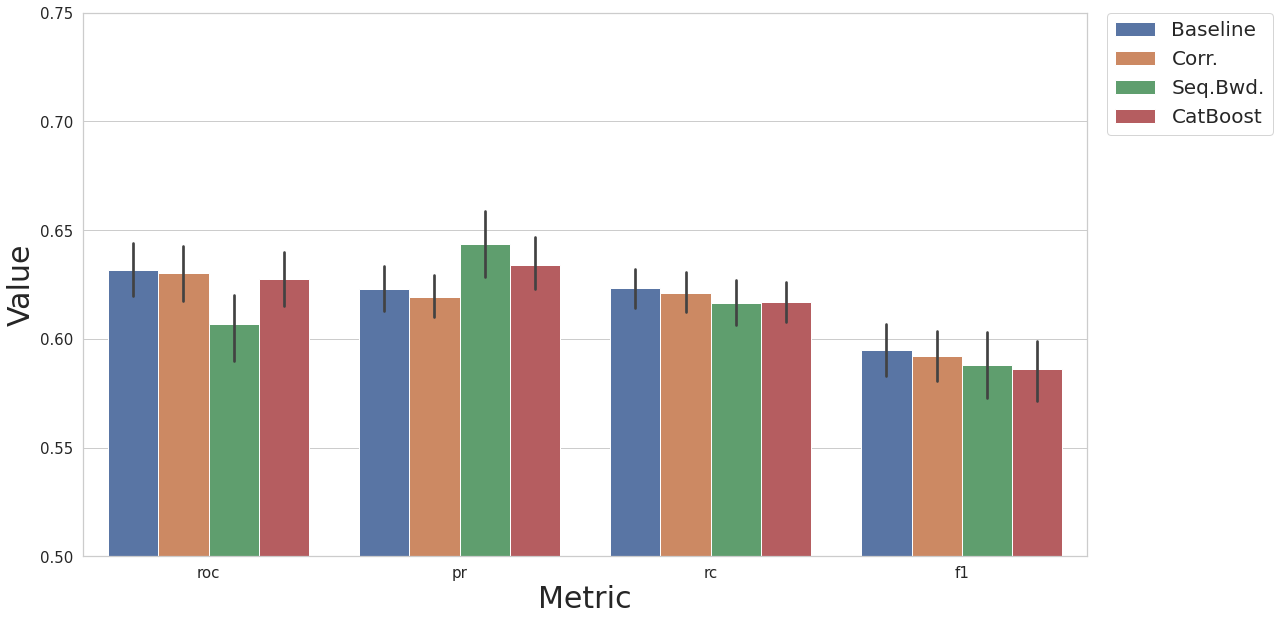

In [13]:
cs.plot_results(result_df)

Some important observations regarding the above graph:
- It seems that by removing highly correlated features (orange bar) results in slightly better results. However, if we check the list of pairs of correlated features in this dataset (check the JSON file **corr_json/c1_corr.json**), we can see that there are none. This means that no features were removed using **CorrelatedFeatures** class, which means that the orange results were generated by the exact same steps as the blue one (baseline). The increased F1 score for the orange experiment is a mere coincidence. This is also expected, since the standard deviation error is relatively high (the small black lines on top of each bar). The high standard deviation is also expected because of the small size of the dataset, which makes the train/test split even more important;
- The other two feature selection experiments (green and red bars) didn't provide any improvements with a statistical significance.

#### Artificial Instances - SMOTE

The next set of experiments aims to test the efficiency of the SMOTE and TOMEK Links (over and under sampling, respectively). Here we perform 3 experiments:
- Baseline dataset (only encoding and imputation applied)
- Baseline dataset + over sampling (using the **Rebalance** class)
- Baseline dataset + over and under sampling (using the **Rebalance** class).

In [14]:
MODEL_NAME = "knn"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

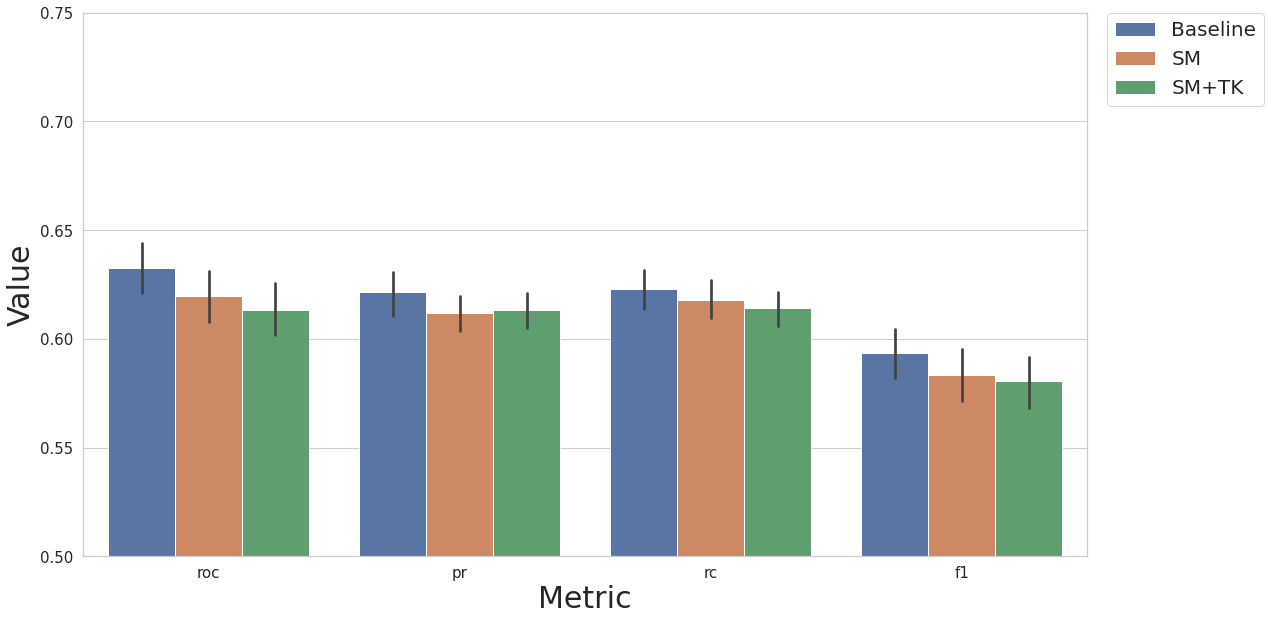

In [15]:
cs.plot_results(result_df)

#### Artificial Instances - CTGAN

Instead of doing over sampling using SMOTE and its variations, we can create artificial instances of the minority class using the CTGAN. Here we perform 3 experiments:
- Baseline dataset (only encoding and imputation applied)
- Baseline dataset + over sampling with CTGAN (using the **Synthesizer** class) with a minority/majority ration of 0.6
- Baseline dataset + over sampling with CTGAN (using the **Synthesizer** class) with a minority/majority ration of 0.9

In [16]:
MODEL_NAME = "knn"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.6, savefile="1_1.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.6")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.9, savefile="1_2.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.9")


/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

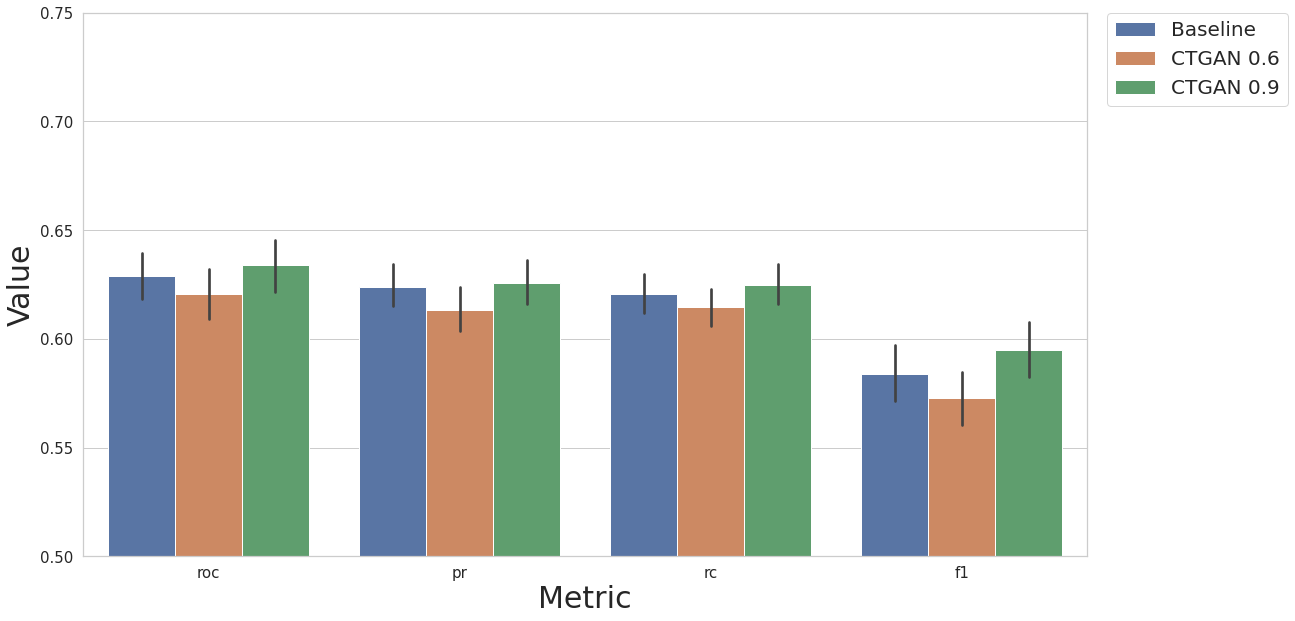

In [18]:
cs.plot_results(result_df)

### XGBoost

#### Feature Selection

In [19]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

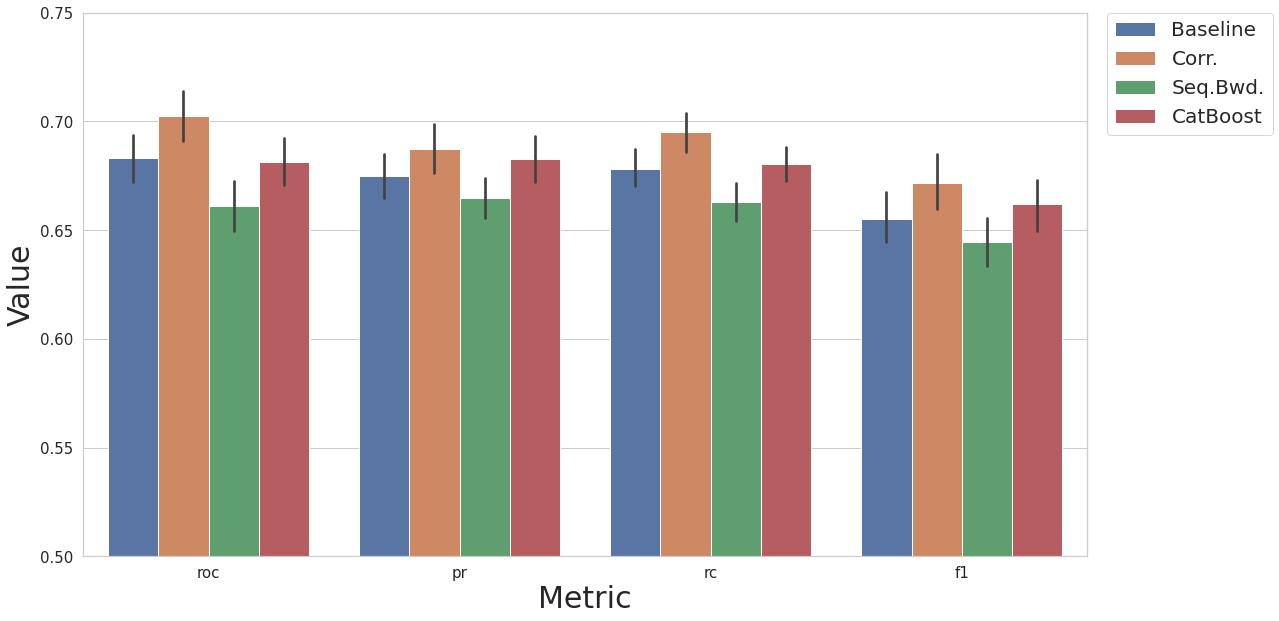

In [20]:
cs.plot_results(result_df)

#### Artificial Instances - SMOTE

In [21]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.7, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

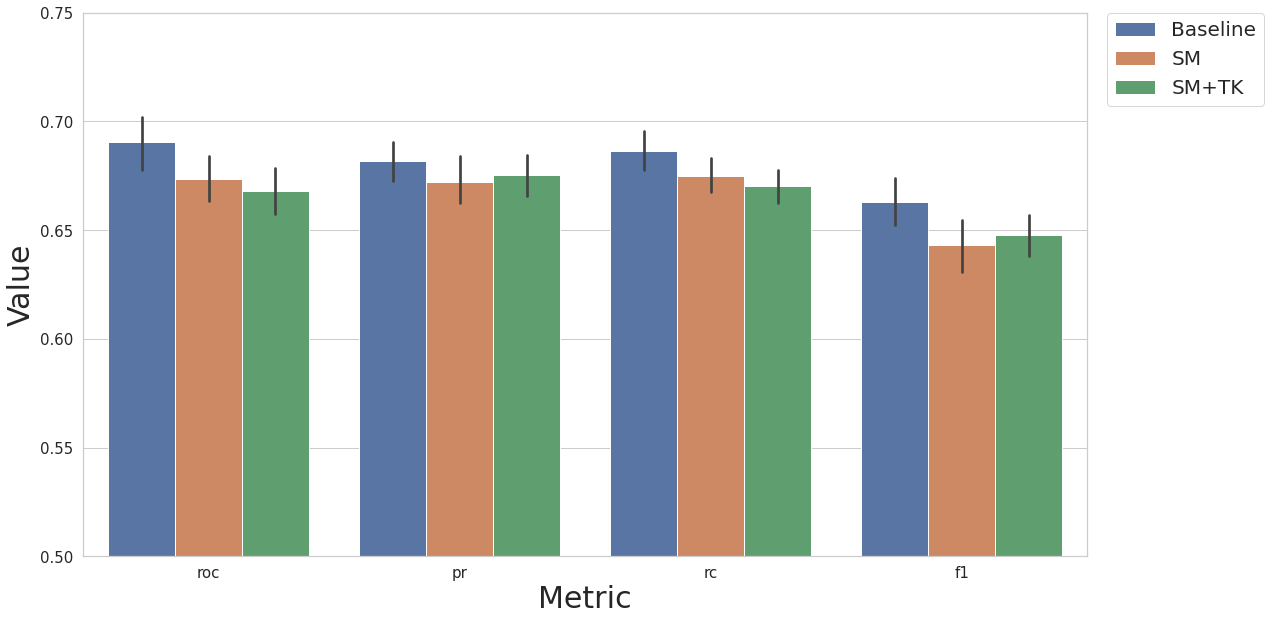

In [22]:
cs.plot_results(result_df)

#### Artificial Instances - CTGAN

In [23]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.6, savefile="1_3.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.6")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type=None, art_str=0.9, savefile="1_4.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.9")


/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

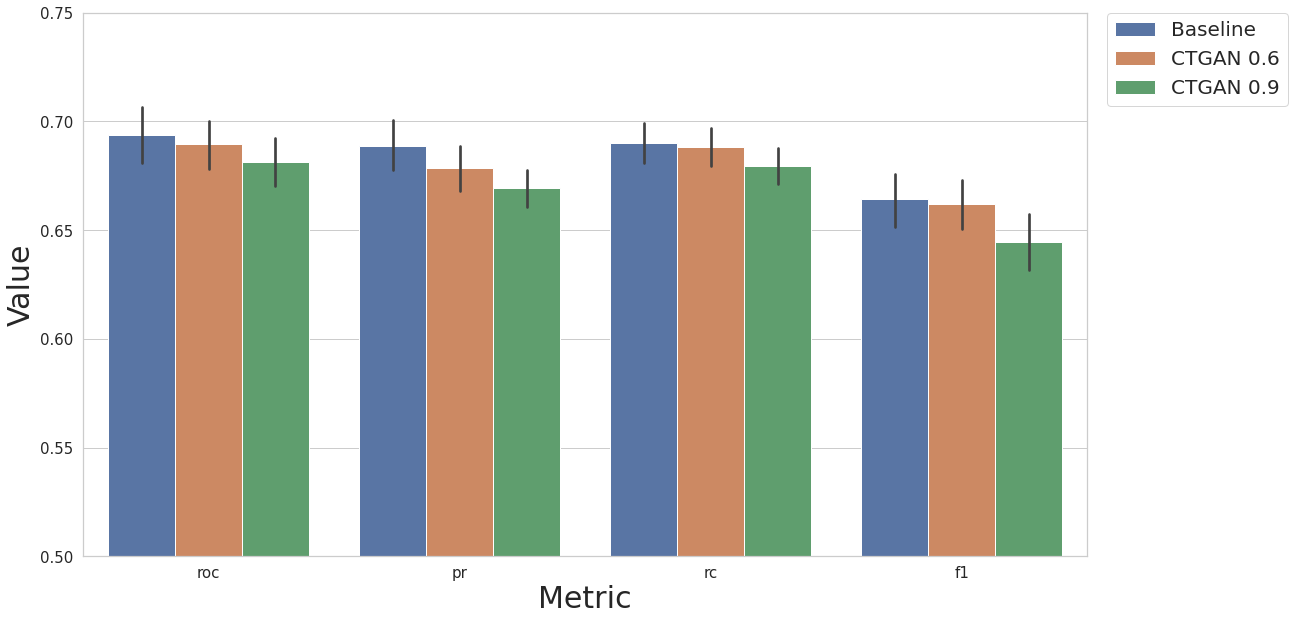

In [24]:
cs.plot_results(result_df)